# Density profile fit

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.optimize import minimize
from density_profile_fit_utils import *
import matplotlib

In [2]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
    "SigmaConstant10": "SigmaConstant10",
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

Utils

In [3]:
def bin_centers(radial_bins):
    outer = radial_bins[1:]
    inner = radial_bins[:-1]
    return 0.5 * (outer + inner)

def select_above_floor(radial_bins, density):
    single_vol = lambda x: (4.0 / 3.0) * np.pi * x ** 3
    volume = single_vol(radial_bins[1:]) - single_vol(radial_bins[:-1])
    density_floor = 1e6 * 10 / volume # 10 particles per unit volume
    return np.where(density - density_floor > 0)[0]

bins = np.arange(-1, 3.1, 0.1)
bins = 10 ** bins
mybins = bin_centers(bins)  # kpc

### Fitting routine example

In [4]:
HALO = 266832

In [5]:
with h5py.File(DATA_PATH+f"SigmaConstant00.hdf5", "r") as file:

    data_subhalo = file[f'{HALO}']['halo_data']
    centers = data_subhalo['centered_radial_bins'][:]
    density = data_subhalo['dm_density'][:]
    selected_bins = select_above_floor(mybins, density)
    
    x, y = centers[selected_bins], density[selected_bins]
    nozero = y > 0
    x = x[nozero]
    y = y[nozero]

    # Let's define inner region as everything within 25 kpc
    inner = np.where((x <= 5) & (x >= 0.5))[0]

    x = x[inner]
    y = np.log10(y[inner])
    yerr = np.ones(len(y)) * 0.1

    ### NFW
    np.random.seed(42)
    nll = lambda *args: -log_likelihood_nfw(*args)
    initial = np.array([1, 7])
    soln = minimize(nll, initial, args=(x, y, yerr))
    r0, rho0 = soln.x
    print('=======')

    sampler_nfw, r0_nfw, rho0_nfw, _, _ = run_mcmc_nfw(x, y, yerr, soln)
    
    ### Core-NFW
    np.random.seed(42)
    nll = lambda *args: -log_likelihood_core_nfw(*args)
    initial = np.array([9, 1, 0.01])
    soln.x = initial
    # soln = minimize(nll, initial, args=(x, y, yerr))
    # log10_M200_0, rc_0, n_0 = soln.x
    print('=======')
    
    sampler_core_nfw, log10_M200_core_nfw, rc_core_nfw, n_core_nfw, _, _, _= run_mcmc_core_nfw(x, y, yerr, soln)
    
    ### Isothermal
    np.random.seed(42)
    nll = lambda *args: -log_likelihood_iso(*args)
    initial = np.array([1, 7])
    soln = minimize(nll, initial, args=(x, y, yerr))
    r0, rho0 = soln.x
    print('=======')

    sampler_iso, r0_iso, rho0_iso, _, _ = run_mcmc_iso(x, y, yerr, soln)
    
    file.close()

100%|██████████| 5000/5000 [00:35<00:00, 142.00it/s]


100%|██████████| 5000/5000 [00:41<00:00, 120.15it/s]


100%|██████████| 5000/5000 [01:53<00:00, 43.89it/s]


### Plotting routine

### NFW ###
r0 5.538619781779106 1.72756266546253
rho0 6.362946580501742 0.20806569075348186
### Core NFW ###
$\log_{10} \text{M}_{200}$ 9.510567416805554 0.08995095543391349
r_c 4.2732900434904835 2.3641868456535926
n 0.42640296905191977 0.21132022433910144
### Isothermal ###
r0 0.5920925580142822 0.06447417999619369
rho0 7.1552121412442435 0.07913510184990626


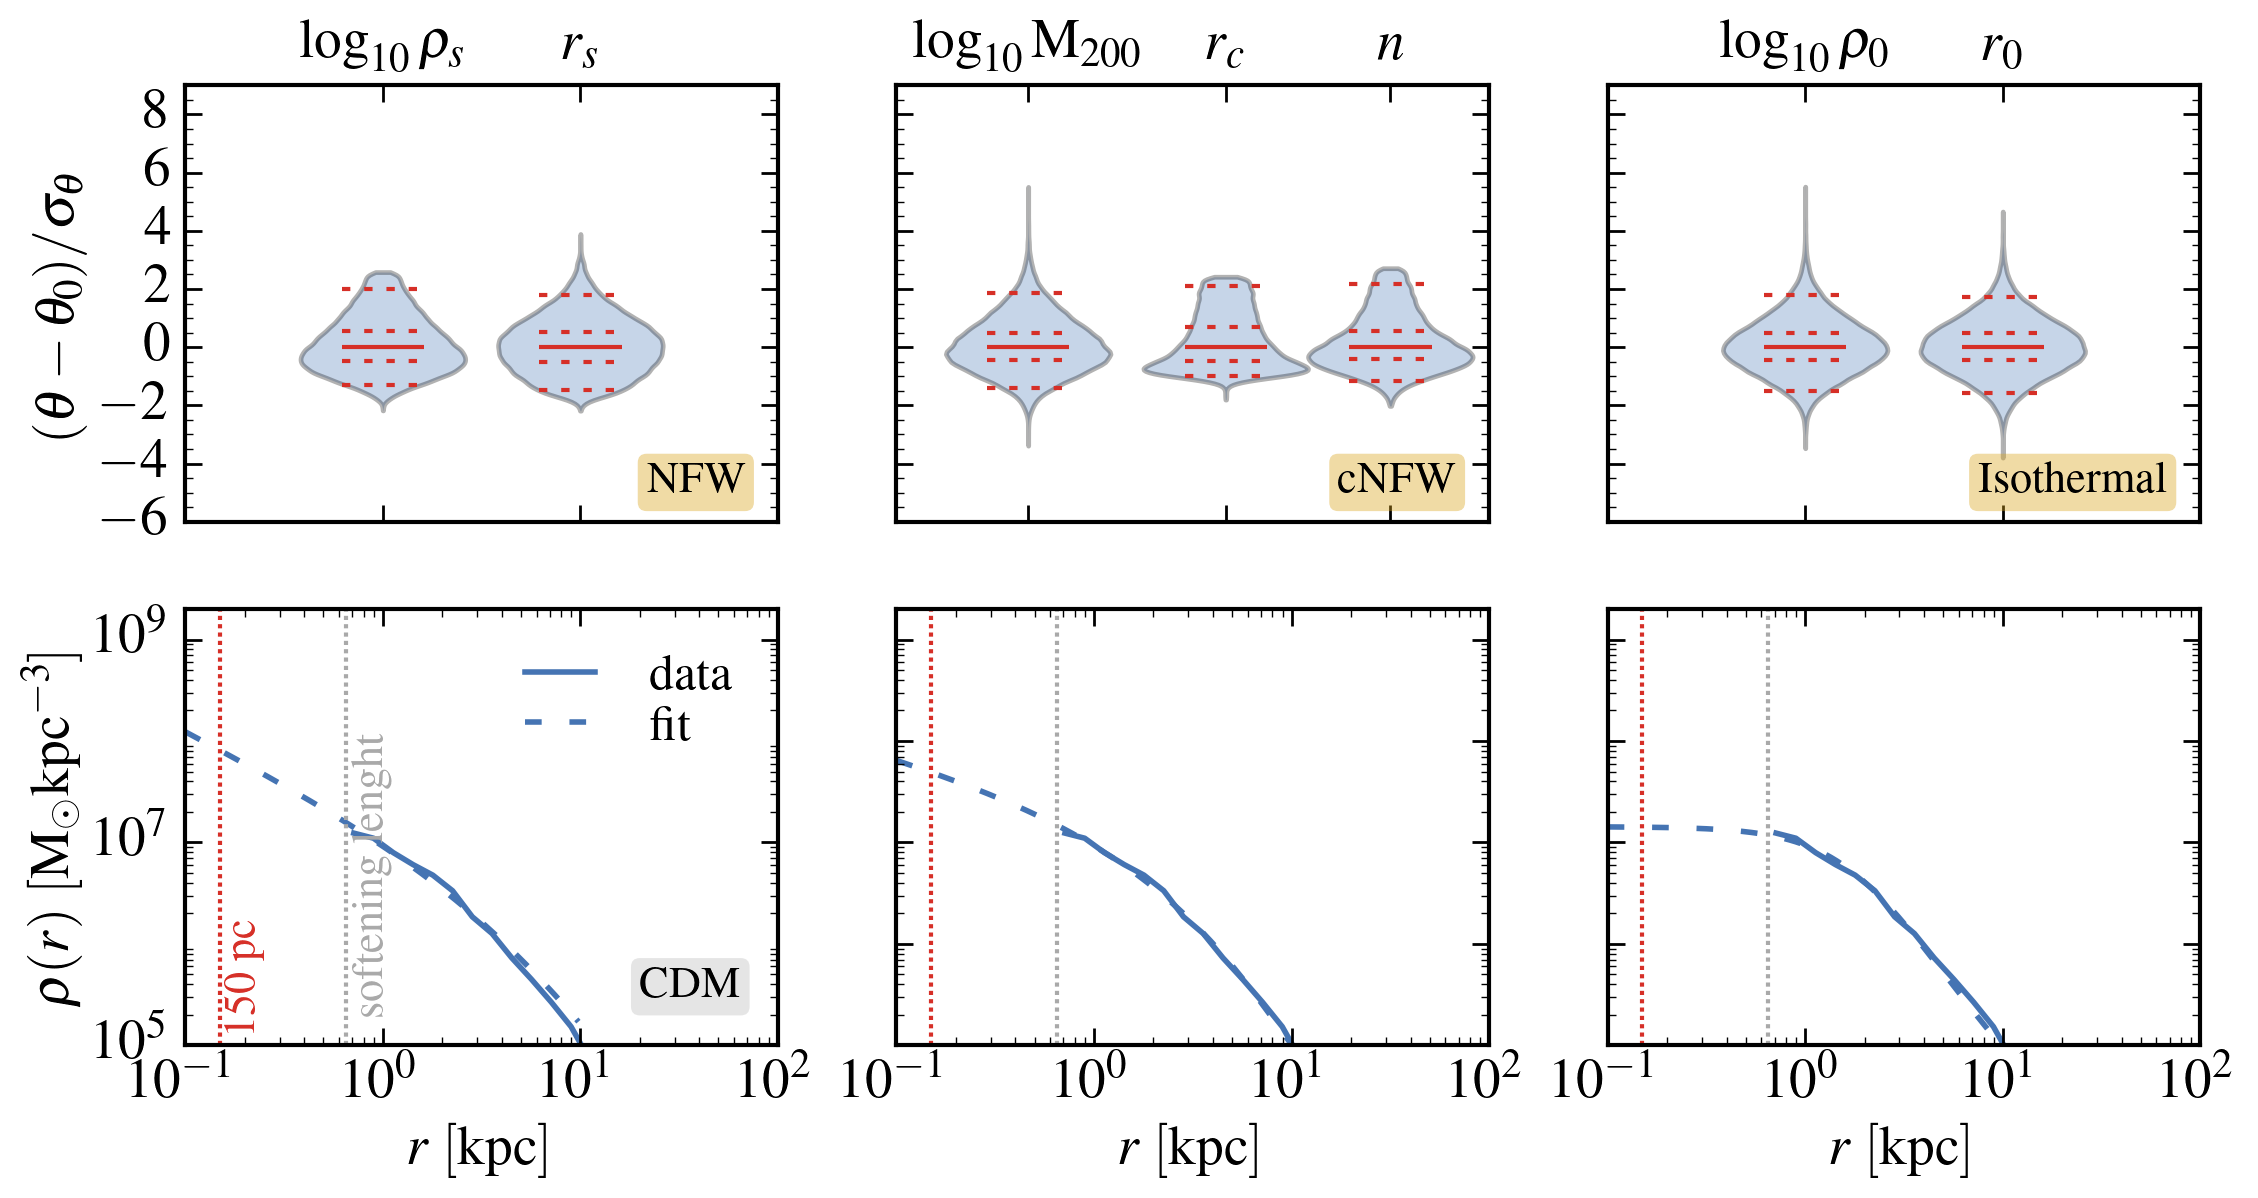

In [20]:
plt.style.use("pltstyle.mplstyle")

mycmap = matplotlib.cm.RdYlBu
myred = mycmap(0.1)
myblue =  mycmap(0.9)

def plot_parts(parts):
    parts['cmedians'].set_color(myred)
    parts['cquantiles'].set_color(myred)
    parts['cquantiles'].set_linestyle('--')
    for pb in parts['bodies']:
        pb.set_facecolor(myblue)
        pb.set_alpha(0.3)



fig, axs = plt.subplots(2, 3, figsize=(13,6), dpi=200, facecolor='white') 
axs1, axs0 = axs

with h5py.File(DATA_PATH+f"SigmaConstant00.hdf5", "r") as file:
    id_name = "CDM"

    data_subhalo = file[f'{HALO}']['halo_data']
    centered_radial_bins = data_subhalo["centered_radial_bins"][:]
    density = data_subhalo["dm_density"][:]
    selected_bins = select_above_floor(mybins, density)
    centered_radial_bins = centered_radial_bins[selected_bins]
    density = density[selected_bins]
    
    xrange = np.arange(-1, 1, 0.01)
    xrange = 10**xrange

    ### NFW
    print('### NFW ###')
    model = fit_nfw_model(xrange, r0_nfw, rho0_nfw)
    tau = sampler_nfw.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    samples = sampler_nfw.get_chain(discard=burnin, flat=True, thin=1)
    # samples = sampler_nfw.get_chain(flat=True)
    label = [r"$\log_{10} \rho_s$", r"$r_s$"]
    fit = 'NFW'
    
    print('r0', r0_nfw, samples[:, 0].std())
    print('rho0', rho0_nfw, samples[:, 1].std())
    samples_r0 = (samples[:, 0] - r0_nfw) / samples[:, 0].std()
    samples_rho0 = (samples[:, 1] - rho0_nfw) / samples[:, 1].std()
    data = [samples_r0, samples_rho0]
    pos = [0.8, 1.4]
    axs1[0].set_xticks(pos, labels=label)
    parts = axs1[0].violinplot(data, positions=pos, showmedians=True, showextrema=False, quantiles=[[0.05, 0.32, 0.68, 0.95],]*2)
    plot_parts(parts)
    
    axs0[0].loglog(centered_radial_bins, density, c=myblue, lw=2) 
    axs0[0].loglog(xrange, 10**model, ls='--', c=myblue, lw=2) 
    axs1[0].text(1.9, -5, fr'$\mathrm{{{fit}}}$', color='black', fontsize=16, horizontalalignment='right',
                bbox=dict(facecolor='goldenrod', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'))

    
    ### Core NFW 
    print('### Core NFW ###')
    model = fit_core_nfw_model(xrange, log10_M200_core_nfw, rc_core_nfw, n_core_nfw)
    tau = sampler_core_nfw.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    samples = sampler_core_nfw.get_chain(discard=burnin, flat=True, thin=1)
    # samples = sampler_core_nfw.get_chain(flat=True)
    label = [r"$\log_{10} \mathrm{M}_{200} $", r"$r_c$", r"$n$"]
    fit = 'cNFW'
    
    print(r'$\log_{10} \text{M}_{200}$', log10_M200_core_nfw, samples[:, 0].std())
    print('r_c', rc_core_nfw, samples[:, 1].std())
    print('n', n_core_nfw, samples[:, 2].std())
    samples_log10M200 = (samples[:, 0] - log10_M200_core_nfw) / samples[:, 0].std()
    samples_rc = (samples[:, 1] - rc_core_nfw) / samples[:, 1].std()
    samples_n = (samples[:, 2] - n_core_nfw) / samples[:, 2].std()
    data = [samples_log10M200, samples_rc, samples_n]
    pos = [0.6, 1.2, 1.7]
    axs1[1].set_xticks(pos, labels=label)
    parts = axs1[1].violinplot(data, positions=pos, showmedians=True, showextrema=False, quantiles=[[0.05, 0.32, 0.68, 0.95],]*3)
    plot_parts(parts)
    
    axs0[1].loglog(centered_radial_bins, density, c=myblue, lw=2) 
    axs0[1].loglog(xrange, 10**model, ls='--', c=myblue, lw=2) 
    axs1[1].text(1.9, -5, fr'$\mathrm{{{fit}}}$', color='black', fontsize=16, horizontalalignment='right',
                bbox=dict(facecolor='goldenrod', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'))
    
    ### Isothermal 
    print('### Isothermal ###')
    model = fit_isothermal_model(xrange, r0_iso, rho0_iso)
    tau = sampler_iso.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    samples = sampler_iso.get_chain(discard=burnin, flat=True, thin=1)
    # samples = sampler_iso.get_chain(flat=True)
    label = [r"$\log_{10} \rho_0 $", r"$r_0$"]
    fit = 'Isothermal'
    
    print('r0', r0_iso, samples[:, 0].std())
    print('rho0', rho0_iso, samples[:, 1].std())
    samples_r0 = (samples[:, 0] - r0_iso) / samples[:, 0].std()
    samples_rho0 = (samples[:, 1] - rho0_iso) / samples[:, 1].std()
    data = [samples_r0, samples_rho0]
    pos = [0.8, 1.4]
    axs1[2].set_xticks(pos, labels=label)
    parts = axs1[2].violinplot(data, positions=pos, showmedians=True, showextrema=False, quantiles=[[0.05, 0.32, 0.68, 0.95],]*2)
    plot_parts(parts)
    
    axs0[2].loglog(centered_radial_bins, density, c=myblue, lw=2) 
    axs0[2].loglog(xrange, 10**model, ls='--', c=myblue, lw=2) 
    axs1[2].text(1.9, -5, fr'$\mathrm{{{fit}}}$', color='black', fontsize=16, horizontalalignment='right',
                bbox=dict(facecolor='goldenrod', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'))
        
for ax in axs1:
    ax.set_ylim(-6, 9)
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('both')
    ax.set_xlim(0.2,2.)
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    
for ax in axs0:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e5, 2e9)
    ax.set_xlabel(r"$r \ [\mathrm{kpc}]$")
    ax.axvline(0.65, c='darkgray', ls=(0, (1, 1)))
    ax.axvline(0.15, c=myred, ls=(0, (1, 1)))
    
axs0[0].text(20, 3e5, fr'CDM', color='black', fontsize=16, bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'))
axs0[0].plot([],[], lw=2, ls='-', color=myblue, label=r'$\mathrm{data}$')
axs0[0].plot([],[], lw=2, ls='--', color=myblue, label=r'$\mathrm{fit}$')
axs0[0].legend(labelspacing=0.1, fontsize=18, loc='upper right', markerscale=2.8)
axs0[1].set_yticklabels([])
axs1[1].set_yticklabels([])
axs0[2].set_yticklabels([])
axs1[2].set_yticklabels([])

axs1[0].set_ylabel(r"$(\theta - \theta_0)/\sigma_{\theta}$")
axs0[0].text(0.7, 5e6, "$\mathrm{softening\ lenght}$", c='darkgray', rotation=90, verticalalignment='center')
axs0[0].text(0.158, 5e5, r"$150 \mathrm{\ pc}$", c=myred, rotation=90, verticalalignment='center')
axs0[0].set_yticks([1e5, 1e7, 1e9])
axs0[0].set_ylabel(r"$\rho(r) \ [\mathrm{M_\odot kpc^{-3}}]$")

plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.tight_layout()
fig.savefig("./figures/mcmc_fit_base.png", dpi=300, transparent=True)